In [29]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [30]:
def showImages(imgs, names, width=10, height=10):
    # changing the size of canvas
    plt.rcParams['figure.figsize'] = [width, height] 

    plot = 130
    for i in range(len(imgs)):
        plot += 1
        plt.subplot(plot), plt.imshow(imgs[i], cmap='gray'), plt.title(names[i])
    plt.tight_layout()
    plt.show()


In [31]:
def laplacianMask(shape):
    # mask with 2 planes because we have real and imaginary values in filter
    mask = np.zeros((shape[0], shape[1], 2), dtype='float32')
    M = shape[0] # width
    N = shape[1] # height

    for i in range(M):
        for j in range(N):
            mask[i][j] = -((i-M/2)**2 + (j-N/2)**2)
    return mask

In [32]:
if __name__ == '__main__':
    img = cv2.imread('car.jpg',0)
    img_float32 = np.float32(img)

In [33]:
    dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)

    dft_shift = np.fft.fftshift(dft)

In [34]:
    mask = laplacianMask(img.shape)
    
    # apply mask and inverse DFT
    fshift = dft_shift*mask

    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)

    img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

-539200.0


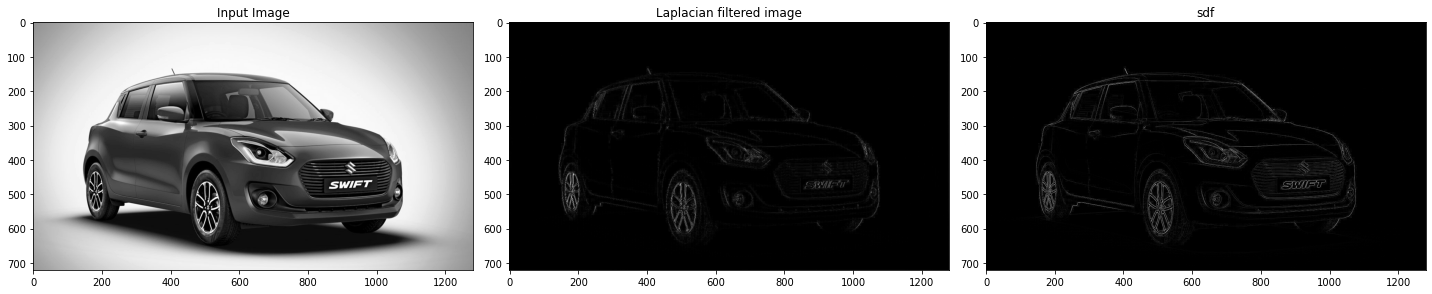

In [38]:
    lap = cv2.Laplacian(img, -1)
    showImages([img, img_back, lap], ['Input Image', 'Laplacian filtered image', 'sdf'], 20, 10)